In [74]:
#pip install ucimlrepo

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [76]:
from ucimlrepo import fetch_ucirepo 
  
# Descargar dataset
maternal_health_risk = fetch_ucirepo(id=863) 
  
# Separar datos, (Pandas DataFrame)
X = maternal_health_risk.data.features 
y = maternal_health_risk.data.targets 
  
# Información básica del dataset
print("URL del repositorio: {}".format(maternal_health_risk.metadata['repository_url']))
print("Descripción del dataset: {}".format(maternal_health_risk.metadata['abstract']))
print("Tarea: {}".format(maternal_health_risk.metadata['tasks'][0]))
print('\nDescripción de los datos')
  
# Información de las variables
maternal_health_risk.variables

URL del repositorio: https://archive.ics.uci.edu/dataset/863/maternal+health+risk
Descripción del dataset: Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.
Tarea: Classification

Descripción de los datos


,name,role,type,demographic,description,units,missing_values
0,Age,Feature,Integer,Age,Any ages in years when a women during pregnant.,None,no
1,SystolicBP,Feature,Integer,None,"Upper value of Blood Pressure in mmHg, another...",None,no
2,DiastolicBP,Feature,Integer,None,"Lower value of Blood Pressure in mmHg, another...",None,no
3,BS,Feature,Integer,None,Blood glucose levels is in terms of a molar co...,mmol/L,no
4,BodyTemp,Feature,Integer,None,None,F,no
5,HeartRate,Feature,Integer,None,A normal resting heart rate,bpm,no
6,RiskLevel,Target,Categorical,None,Predicted Risk Intensity Level during pregnanc...,None,no


In [77]:
# Visualizar información de las variables independientes (features)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 47.7 KB


De las variables independiente se observa lo siguiente:
1. El tamaño del dataset es de 6 columnas con 1014 registros. 
2. El dataset tiene 6 caracterísricas numéricas, dos de ellas son de tipo float64 que corresponden a BS (Niveles de glucosa en sangre) y Body Temp (Temperatura del cuerpo).
3. No hay valores nulos

In [78]:
# Visualizar información del objetivo (target)
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   RiskLevel  1014 non-null   object
dtypes: object(1)
memory usage: 8.1+ KB


De la variable objetivo se observa lo siguiente:
1. El tamaño es de 1 columna y 1014 registros que corresponde a la cantidad de registros de las variables independientes.
2. Las variables son no numéricas.
2. No hay valores nulos.

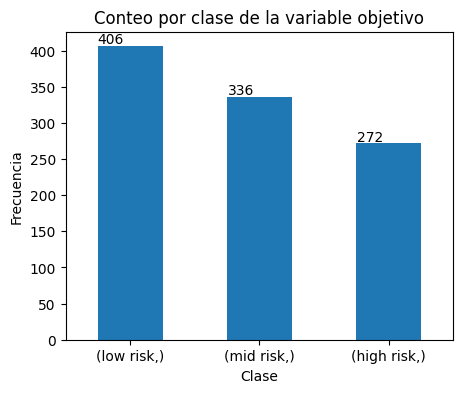

In [79]:
# Sumar la cantidad de datos por clase
y_values = y.value_counts()

# Visualizar distribución
plt.figure(figsize=(5,4)) 
ax = y_values.plot(kind='bar')

# Etiquetado
plt.title("Conteo por clase de la variable objetivo")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")

plt.xticks(rotation=0)


# Añadir etiquetas encima de las barras
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.01))

Se observa un desbalance en las clases de la variable objetivo de donde el 27% de los datos corresponde a la clase "high risk" el 33% a la clase "mid risk" y el 40% a la clase "low risk".
Existen varias técnicas para evitar que el modelo se sesge a la clase mayoritaria, algunas técnicas son:
1. Submuestreo de la clase mayoritaria: Debido a que el dataset es relativamente pequeño se evitará hacer esto.
2. Sobremuestreo: Aplicar la técnica SMOTE para aumentar la clase minoritaria.
3. Ajustar los pesos del modelo: Se podría dar más peso a la clase minoritaria durante la fase del entrenamiento.

Se optará por la opción 3.

In [80]:
# Estadísticas descriptivas de las variables independientes.
X.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


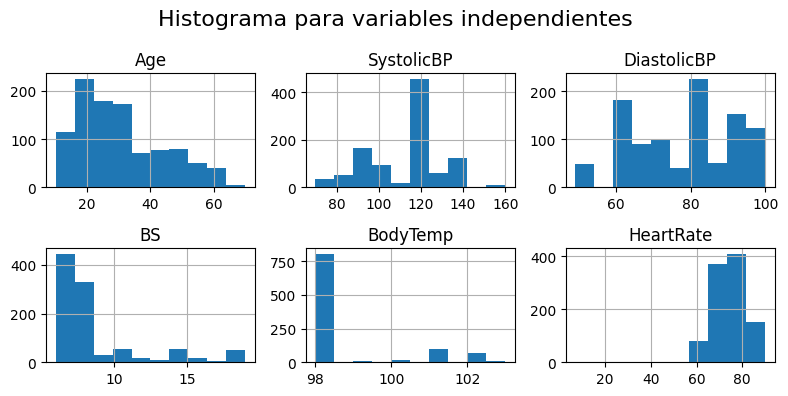

In [81]:
# Visualizar distribución de los datos
X.hist(layout=(2, 3), figsize=(8, 4),bins=10)

# Etiquetado
plt.suptitle("Histograma para variables independientes", fontsize=16)

plt.tight_layout()

In [82]:
# Obtener sesgos
X.skew()

Age            0.783063
SystolicBP    -0.251189
DiastolicBP   -0.048441
BS             1.868203
BodyTemp       1.750988
HeartRate     -1.043525
dtype: float64

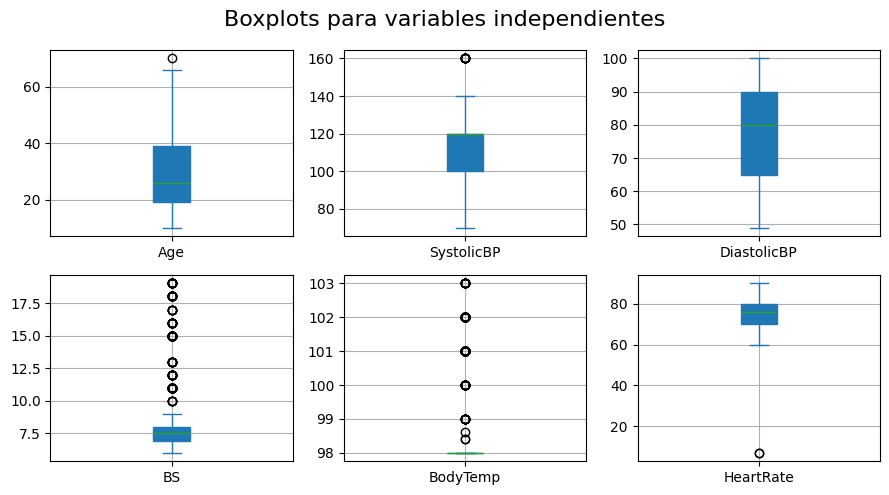

In [83]:
# Visualizar boxplot para encontrar datos atípicos
X.plot(kind='box',figsize = (9, 5),subplots=True,layout=(2,3),patch_artist=True, grid=True)
plt.suptitle("Boxplots para variables independientes", fontsize=16)
plt.tight_layout()

In [84]:
# Obtener cantidad de outliers

# Calcular Q1 y Q3 para todas las columnas
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)

# Calcular el IQR para cada columna
IQR = Q3 - Q1

# Identificar outliers
outliers = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Contar cuántos outliers existen en cada columna
outliers_count = outliers.sum()

# Mostrar resultado
print("Outliers por variable independiente")
print(outliers_count)

Outliers por variable independiente
Age              1
SystolicBP      10
DiastolicBP      0
BS             210
BodyTemp       210
HeartRate        2
dtype: int64


De las estadísticas descriptivas en conjunto con la visualizaciones observamos lo siguiente:
- Age: La mayoría de los datos predominan entre los 20 a 40 años, con algunos datos atipicos a los 70 años, lo cual es coherente con el sesgo positivo encontrado.
- SystolicBP: Se observa un seso ligeramente negativo igual a -0.25, los datos predominan entre los 100 a 120 siendo 113 la media y datos máximos de 160 considerados como atípicos.
- DiastolicBP: La media de los datos se encuentra en 76, no se observan datos atípicos, la distribución se observa relativamente simétrica que está en relación con el valor de asimetría igual a -0.048.
- BS: Se observa gran cantidad de datos atípicos con máximos de 19 cuando la media ronda en 8.72, se observa un sesgo altamente positivo igual a 1.87.
- BodyTemp: Al igual que BS se observa un nivel alto de datos atípicos alcanzado un máximo de 103 cuando la media es de 98 con desviación estándar de 1.37, tambień se observa sesgo positivo igual a 1.75.
- HeartRate: Se observa sesgo negativo debido a datos átipicos igual a 7.0 muy por debajo de la media que es de 74.3, seguramente el dato igual a 7 corresponde a un error en el registro de los datos.

Text(0.5, 1.0, 'Matriz de correlacion')

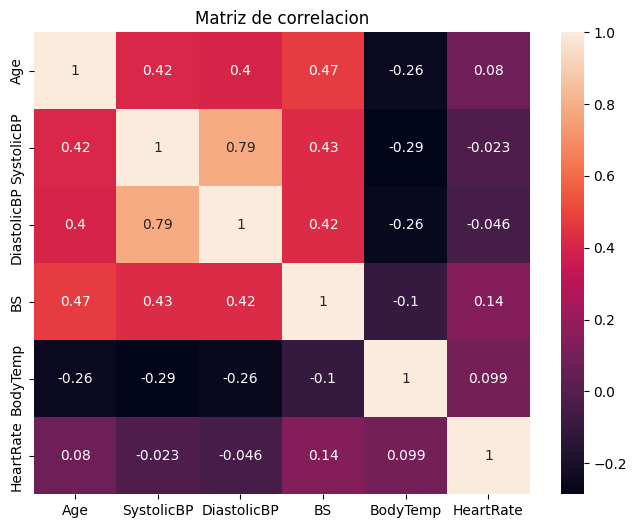

In [85]:
# Análisis de correlacion
corr_matrix = X.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix,annot=True,)
plt.title("Matriz de correlacion")

De la matriz de correlación se observa lo siguiente:
- Existe alta correlación positiva entre DiastolicBP y SystolicBP, lo cual es de esperarse ya que cuando una sube, la otra también.
- Tanto SystolicBP como SystolicBP están correlacionadas con la edad de forma positiva con un valor cercano a 0.4, lo cual indica que con el aumento de la edad la presión aumenta.
- De igual manera BS que es Glucosa en sangre está correlacionada positivamente con SystolicBP y SystolicBP, lo que indica que mayor nivel de glucosa en sangre mayor es la presión.
- BodyTemp y Heart rate presentan correlaciones cercanas a cero, lo que indica que no existe una relación relevante con las variables.

In [86]:
# Para el caso de Age y Heart, no se eliminaran los outliers, 
# serán reemplazados por la media
X.loc[outliers['HeartRate'], 'HeartRate'] = int(X['HeartRate'].mean())
X.loc[outliers['Age'], 'Age'] = int(X['Age'].mean())

In [87]:
# Crear un nuevo dataframe para almacenar las variables independientes
# transformadas
XT = pd.DataFrame()

# Aplicar la transformación inversa se añade una pequeña constante para evitar división por 0 

XT['Age'] = np.sqrt(X['Age'])
XT['SystolicBP']=np.sqrt(X['SystolicBP'])
XT['DiastolicBP']=np.sqrt(X['DiastolicBP'])

XT['HeartRate'] = 1 / (X['HeartRate'] + 1e-9)
XT['BodyTemp']  = 1 / (X['BodyTemp'] + 1e-9)
XT['BS'] = 1 / (X['BS'] + 1e-9)

# Normalizar datos 
normalizer = MinMaxScaler()
# Aplicar la normalización 
XT_normalized = pd.DataFrame(normalizer.fit_transform(XT), columns=XT.columns)

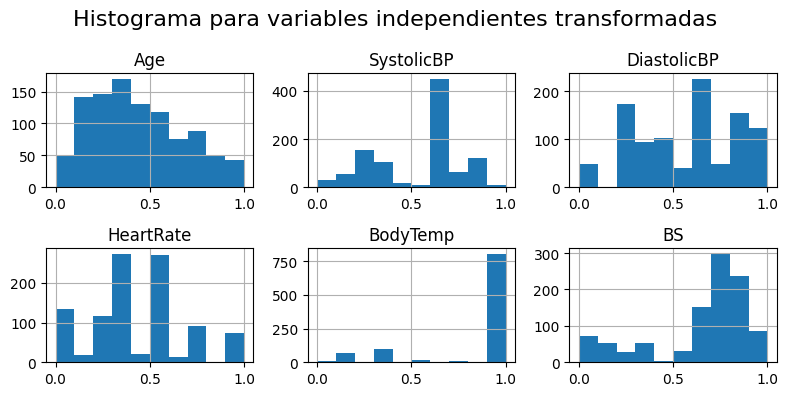

In [88]:
# Visualizar distribución de los datos
XT_normalized.hist(layout=(2, 3), figsize=(8, 4),bins=10)

# Etiquetado
plt.suptitle("Histograma para variables independientes transformadas", fontsize=16)

plt.tight_layout()

### Codificación de clases

In [89]:
# Codificar la variable target, debido a que las etiquetas son high risk, mid risk y low risk.
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(y)

/Users/devzaga/.pyenv/versions/3.11.7/envs/mariana-2/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
# Visualizar el mapeo de clases
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Mapeo:", class_mapping)

Mapeo: {'high risk': 0, 'low risk': 1, 'mid risk': 2}


### División del conjunto de datos

In [91]:
# Dividir el conjunto de datos, en entrenamiento, validación y pueba.
X_train, X_test, y_train, y_test = train_test_split(XT_normalized, Y, test_size=0.1, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Entrenamiento del modelo 1: Bosque aleatorio

In [92]:
# Peso de las clases de acuerdo al porcentaje de los datos encontrados en EDA
# con la finalidad de compensar el desbalanceo de datos
# el 27% de los datos corresponde a la clase "high risk:0" 
# el 33% a la clase "mid risk:2" 
# el 40% a la clase "low risk:1"
# Se usará el inverso de la proporción para definir los pesos de las clases.

class_weight = {0: 3.70, 1: 3.03, 2: 2.5}

# Definir el modelo 
random_forest_model = RandomForestClassifier(random_state=42,class_weight=class_weight)


# Definir el espacio de hiperparámetros para la búsqueda
param_grid = {
    'n_estimators': [5, 10, 20, 50],             # Número de árboles en el bosque
    'max_depth': [3, 5, 10],                     # Profundidad máxima de los árboles
    'min_samples_split': [3, 5, 10, 20],         # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],               # Número mínimo de muestras en una hoja
    'bootstrap': [True, False]                   # Usar o no muestreo con reemplazo
}

# Inicializar el RandomizedSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, 
                                   param_grid=param_grid, 
                                   scoring='f1_weighted',       
                                   cv=3,                        
                                   verbose=2, 
                                   n_jobs=-1)     
              
# Ajustar el modelo usando la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/Users/devzaga/.pyenv/versions/3.11.7/envs/mariana-2/lib/python3.11/site-packages/

[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_es

/Users/devzaga/.pyenv/versions/3.11.7/envs/mariana-2/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [93]:
# Evaluar el modelo con el conjunto de prueba
y_pred = best_model.predict(X_test)

# Obtener el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Visualizar el reporte
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("\n")
print(report)

Mejores parámetros encontrados: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}


              precision    recall  f1-score   support

   high risk       0.86      0.89      0.87        27
    low risk       0.79      0.78      0.78        40
    mid risk       0.77      0.77      0.77        35

    accuracy                           0.80       102
   macro avg       0.81      0.81      0.81       102
weighted avg       0.80      0.80      0.80       102



### Entrenamiento del modelo 2: KNN

In [94]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9,12,15,20],           # Número de vecinos
    'weights': ['uniform', 'distance'],             # Tipo de ponderación de los vecinos
    'p': [1, 2]                                     # Distancia: p=1: Manhattan, p=2: Euclidiana
}

grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                           param_grid=param_grid,
                           scoring='f1_weighted',  
                           cv=3,                 
                           verbose=2, 
                           n_jobs=-1)            

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_knn_model = grid_search.best_estimator_

# Probar el modelo con los datos de prueba
y_pred_knn = best_knn_model.predict(X_test)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END ...............n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END ...............n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END ...............n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END ................n_neighbors=3, p=2, wei

In [95]:
# Crear el reporte de clasificación
knn_report = classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_)

# Mostrar los mejores parámetros y el reporte de clasificación
print("Mejores parámetros encontrados:", grid_search.best_params_)
print(knn_report)

Mejores parámetros encontrados: {'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

   high risk       0.86      0.89      0.87        27
    low risk       0.87      0.68      0.76        40
    mid risk       0.72      0.89      0.79        35

    accuracy                           0.80       102
   macro avg       0.82      0.82      0.81       102
weighted avg       0.82      0.80      0.80       102



In [96]:
with open("knn_classification_report.txt", "w") as f:
    f.write("Mejores parámetros encontrados: {}\n".format(grid_search.best_params_))
    f.write(knn_report)